In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try: # Currently, memory growth needs to be the same across GPUs 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized print(e)
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from alexnet import AlexNet
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print("[INFO] accessing beans...")
trainData,trainLabels=tfds.load('beans',split='train',as_supervised=True,batch_size=-1)
testData,testLabels=tfds.load('beans',split='test',as_supervised=True,batch_size=-1)

print(trainData.shape)
print(testData.shape)
print(trainLabels.shape)
print(testLabels.shape)

numclass=3
trainLabels=tf.keras.utils.to_categorical(trainLabels,num_classes=numclass)
testLabels=tf.keras.utils.to_categorical(testLabels,num_classes=numclass)

[INFO] accessing beans...
(1034, 500, 500, 3)
(128, 500, 500, 3)
(1034,)
(128,)


In [4]:
print("[INFO] resize images...")

import cv2
import imutils

resizew=227
resizeh=227

temp_train=np.zeros((trainData.shape[0],resizew,resizeh,3))
for i in range(trainData.shape[0]):
    temp=trainData[i].numpy()
    temp=temp.astype("float32") /255.0
    temp_resize=imutils.resize(temp,width=resizew,height=resizeh)
    img_resize=temp_resize.reshape(1,resizew,resizeh,3)
    temp_train[i]=img_resize
    
temp_test=np.zeros((testData.shape[0],resizew,resizeh,3))
for i in range(testData.shape[0]):
    temp=testData[i].numpy()
    temp=temp.astype("float32") /255.0
    temp_resize=imutils.resize(temp,width=resizew,height=resizeh)
    img_resize=temp_resize.reshape(1,resizew,resizeh,3)
    temp_train[i]=img_resize
    
trainData=temp_train
testData=temp_test

print(trainData.shape)
print(testData.shape)

[INFO] resize images...
(1034, 227, 227, 3)
(128, 227, 227, 3)


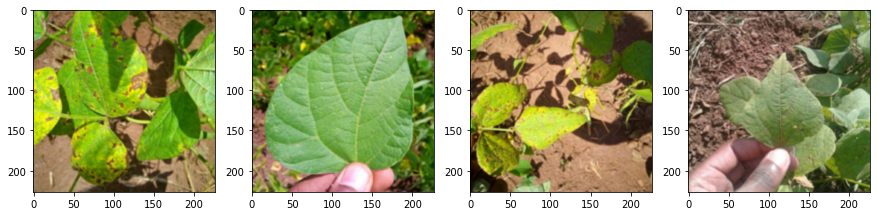

In [5]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(trainData[0],interpolation="bicubic")
plt.grid(False)

plt.subplot(1,4,2)
plt.imshow(trainData[4],interpolation="bicubic")
plt.grid(False)

plt.subplot(1,4,3)
plt.imshow(trainData[8],interpolation="bicubic")
plt.grid(False)

plt.subplot(1,4,4)
plt.imshow(trainData[12],interpolation="bicubic")
plt.grid(False)
plt.show()

In [7]:
#initialize the optimizer and model
print("[INFO] compiling model...")
model=AlexNet.build(width=resizew,height=resizeh,depth=3,classes=numclass)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

# train the Network
print("[INFO] training network...")
epochs=30
H=model.fit(trainData,trainLabels,validation_data=(testData,testLabels),batch_size=32,epochs=epochs)

[INFO] compiling model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_8 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_9 (Activation)   

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.34      1.00      0.50        43
           2       0.00      0.00      0.00        42

    accuracy                           0.34       128
   macro avg       0.11      0.33      0.17       128
weighted avg       0.11      0.34      0.17       128



C:\Users\tjdgu\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tjdgu\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tjdgu\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


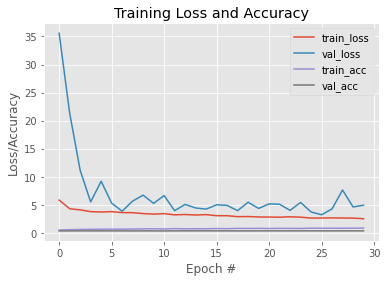

In [8]:
# evaluate the network
print("[INFO] evaluating network...")
predictions=model.predict(testData,batch_size=128)

cr=classification_report(testLabels.argmax(axis=1),predictions.argmax(axis=1),target_names=[str(x) for x in range(numclass)])
print(cr)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,epochs),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,epochs),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,epochs),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,epochs),H.history["val_accuracy"],label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [9]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}